In [12]:
import numpy as np
import sympy as sy
from matplotlib import pyplot as plt
from scipy import interpolate as inter
from numpy import linalg as la
from numpy.fft import fft

In [2]:
def lagrange(xint, yint, points):
    """Find an interpolating polynomial of lowest degree through the points
    (xint, yint) using the Lagrange method and evaluate that polynomial at
    the specified points.

    Parameters:
        xint ((n,) ndarray): x values to be interpolated.
        yint ((n,) ndarray): y values to be interpolated.
        points((m,) ndarray): x values at which to evaluate the polynomial.

    Returns:
        ((m,) ndarray): The value of the polynomial at the specified points.
    """
    n = len(yint)
    evaluate = []
    for i in range(n):
        #calculate denominator = float
        denominator = np.prod(xint[i]- np.delete(xint, i), axis = 0)
        #calculate numerator = ndarray
        numerator = np.prod(points - np.delete(xint,i).reshape(n-1,1),axis = 0)
        #Evaluate = list of ndarrays
        evaluate.append(yint[i] * numerator/denominator)
    #replace each ndarray with the sum of all of its elements
    px = sum(evaluate)
    return px

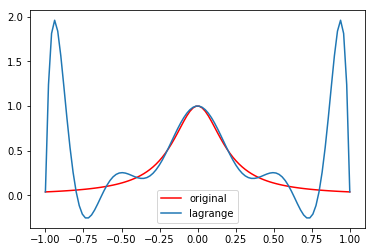

In [3]:
f = lambda x: 1/(1+25*x**2)
domain = np.linspace(-1,1, 100)
iner_dom = np.linspace(-1,1,11)
inter = lagrange(iner_dom,f(iner_dom), domain)
plt.plot(domain,f(domain), 'r', label = 'original')
plt.plot(domain,inter, label='lagrange')
plt.legend()
plt.show()

In [71]:
class Barycentric:
    """Class for performing Barycentric Lagrange interpolation.

    Attributes:
        w ((n,) ndarray): Array of Barycentric weights.
        n (int): Number of interpolation points.
        x ((n,) ndarray): x values of interpolating points.
        y ((n,) ndarray): y values of interpolating points.
    """

    def __init__(self, xint, yint):
        """Calculate the Barycentric weights using initial interpolating points.

        Parameters:
            xint ((n,) ndarray): x values of interpolating points.
            yint ((n,) ndarray): y values of interpolating points.
        """
        self.x = xint
        self.y = yint
        n = len(xint)
        self.C = (np.max(xint) - np.min(xint)) / 4  #capacity of the interval
        w = np.ones(n) # Number of interpolating points
        shuffle = np.random.permutation(n-1)
        for j in range(n):
            temp = (xint[j] - np.delete(xint, j)) / self.C
            #randomized so that the arithmetic does not overflow due to poor ordering
            temp = temp[shuffle]
            w[j] /= np.product(temp)
        self.weights = w

    def __call__(self, points):
        """Using the calcuated Barycentric weights, evaluate the interpolating polynomial
        at points.

        Parameters:
            points ((m,) ndarray): Array of points at which to evaluate the polynomial.

        Returns:
            ((m,) ndarray): Array of values where the polynomial has been computed.
        """
        x = sy.symbols('x')
        f = lambda x : np.sum([(self.weights[i]*self.y[i]) / (x - self.x[i]) for i in range(len(self.x))]) / np.sum([self.weights[i]/(x - self.x[i]) for i in range(len(self.x))])
        out = [] 
        for i in points:
            if i not in self.x:
                out.append(f(i))
            else:
                out.append(self.y[np.where(self.x == i)[0][0]])
        return out 

    def add_weights(self, xint, yint):
        """Update the existing Barycentric weights using newly given interpolating points
        and create new weights equal to the number of new points.

        Parameters:
            xint ((m,) ndarray): x values of new interpolating points.
            yint ((m,) ndarray): y values of new interpolating points.
        """
        #Prep weights to be recalculated
        self.weights /= self.C**(len(self.x) - 1)
        for i,x in enumerate(xint):
            #for each new weight add approprate values into class
            new_weight = 1/np.prod(x-self.x)
            self.weights /= self.x - x
            self.weights = np.append(self.weights, new_weight)
            self.y = np.append(self.y, yint[i])
            self.x = np.append(self.x, xint[i])
        #finish with scaling C and applying it to weights
        self.C = (np.max(self.x) - np.min(self.x)) / 4
        self.weights *= self.C**(len(self.x) - 1)

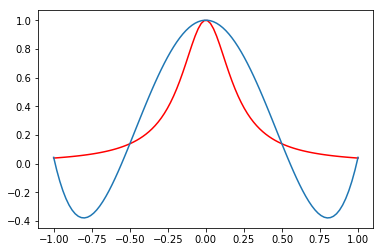

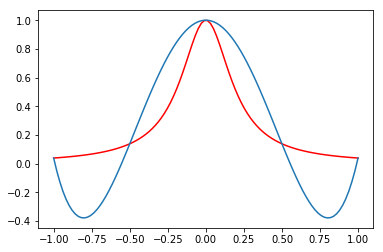

In [72]:
f = lambda x: 1/(1+25*x**2)
domain = np.linspace(-1,1, 100)
iner_dom = np.linspace(-.999,.999,5)

obj = Barycentric(iner_dom, f(iner_dom))(domain)
plt.plot(domain,f(domain), 'r')
plt.plot(domain,obj)
plt.show()

xint = np.array([-1,0,1])
yint = f(xint)
d = Barycentric(xint,yint)
new_x = np.array([-0.5, 0.5])
new_y = f(new_x)
d.add_weights(new_x, new_y)
plt.plot(domain,f(domain), 'r')
plt.plot(domain, d(domain))
plt.show()

In [73]:
def PlotError():
    """For n = 2^2, 2^3, ..., 2^8, calculate the error of intepolating Runge's
    function on [-1,1] with n points using SciPy's BarycentricInterpolator
    class, once with equally spaced points and once with the Chebyshev
    extremal points. Plot the absolute error of the interpolation with each
    method on a log-log plot.
    """
    domain = np.linspace(-1,1, 400)
    n_list = [2**i for i in range(2,9)]
    f = lambda x: 1/(1+25*x**2)

    dist = []
    dist2 = []
    for n in n_list:
        #Get Barycentric poly interpolation
        new_dom = np.linspace(-1,1,n)
        poly = inter.BarycentricInterpolator(new_dom)
        poly.set_yi(f(new_dom))
        #Calculate L-infty norm
        dist.append(la.norm(f(domain) - poly(domain), ord=np.inf))

        #get cheby extrema
        cheb = []
        for j in range(n+1):
            cheb.append(np.cos(j*np.pi/n))
        cheb = np.array(cheb)
        #Barycentric poly at cheby extrema
        poly2 = inter.BarycentricInterpolator(cheb)
        poly2.set_yi(f(cheb))
        #calculate L-infty norm
        dist2.append(la.norm(f(domain) - poly2(domain), ord=np.inf))
    #plot the normes
    plt.loglog(n_list, dist, basex=2, label='Barycentric')
    plt.loglog(n_list, dist2, basex=2, label = 'chebyshev')
    plt.legend()
    plt.show()

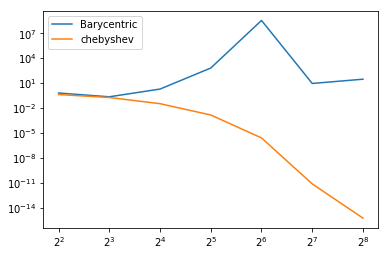

In [74]:
PlotError()

In [14]:
def chebyshev_coeffs(f, n):
    """Obtain the Chebyshev coefficients of a polynomial that interpolates
    the function f at n points.

    Parameters:
        f (function): Function to be interpolated.
        n (int): Number of points at which to interpolate.

    Returns:
        coeffs ((n+1,) ndarray): Chebyshev coefficients for the interpolating polynomial.
    """
    #code from Textbook
    y = np.cos((np.pi*np.arange(2*n)) / n)
    samples = f(y)

    coeffs = np.real(fft(samples))[:n+1] / n
    coeffs[0] = coeffs[0]/2
    coeffs[n] = coeffs[n]/2

    return coeffs

In [15]:
f = lambda x: -3 + 2*x**2 - x**3 + x**4
pcoeffs = [-3, 0, 2, -1, 1]
ccoeffs = np.polynomial.chebyshev.poly2cheb(pcoeffs)
print(ccoeffs)
ccoeffs2 = chebyshev_coeffs(f, len(pcoeffs)-1)
print(ccoeffs2)

[-1.625 -0.75   1.5   -0.25   0.125]
[-1.625 -0.75   1.5   -0.25   0.125]


In [75]:
def InterpolateAirQuality(n):
    """Interpolate the air quality data found in airdata.npy using
    Barycentric Lagrange interpolation. Plot the original data and the
    interpolating polynomial.

    Parameters:
        n (int): Number of interpolating points to use.
    """
    #code from the PDF
    data = np.load('airdata.npy')
    fx = lambda a, b, n: .5*(a+b + (b-a) * np.cos(np.arange(n+1) * np.pi / n))
    a, b = 0, 366 - 1/24
    domain = np.linspace(0, b, 8784)
    points = fx(a, b, n)
    temp = np.abs(points - domain.reshape(8784, 1))
    temp2 = np.argmin(temp, axis=0)
    poly = inter.BarycentricInterpolator(domain[temp2], data[temp2])

    ax1 = plt.subplot(211)
    ax1.scatter(domain, data, s = 2)
    plt.title("Air Data")

    ax2 = plt.subplot(212)
    ax2.plot(domain,poly(domain), 'r')
    plt.title("Poly Fit for Air Data")
    plt.show()

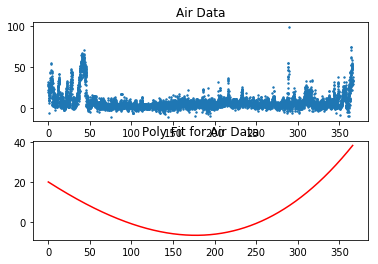

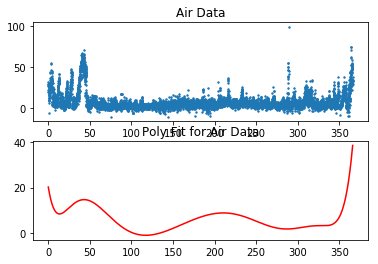

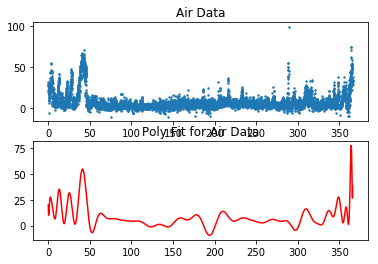

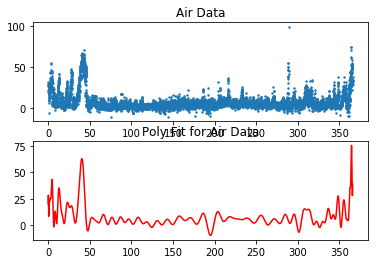

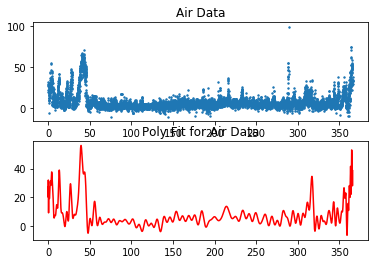

In [76]:
InterpolateAirQuality(3)
InterpolateAirQuality(10)
InterpolateAirQuality(50)
InterpolateAirQuality(100)
InterpolateAirQuality(155) #highest feasable number of interpolating points